In [1]:
import cv2
import os
import pandas as pd

import torch
from torch import nn
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import transforms, datasets 
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet

In [23]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, basePath, modelName, low_res, high_res, EPOCHS, LR, batchSize, ):
        self.trainPath = basePath + "train/"
        self.testPath = basePath + "test/"
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.low_res = (low_res, low_res)
        self.high_res = (high_res, high_res)
        self.train_validate_percent = 0.95
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.modelName = modelName

config = Configuration(basePath="../datasets/Retinal_OCT/", modelName="efficientnet-b0", low_res=32, high_res=128, EPOCHS=25, LR=0.0001, batchSize=64, )

In [31]:
class SRGAN_Dataset(Dataset):
    
    # Init has to find all paths to image and labels
    def __init__(self, root_dir, low_res=(32,32), transform=None):

        self.root_dir = root_dir
        self.transform = transform
        self.low_res = low_res
        
        # Classifications of the objects
        self.definitions = os.listdir(self.root_dir)
        
        data = []
        # Go through each defination and add each image path to the csv
        for label in self.definitions:
            label_path = self.root_dir + label + "/"
            
            for image in os.listdir(label_path):
                
                # Check if file is of an image type
                if image.split('.')[-1] not in ["png", "jpg", "jpeg"]:
                    continue
                
                # If it is, then append the path to the image as well as the label given by the folder
                data.append({
                    'path': label_path + image,
                    'label': self.definitions.index(label)
                })
        
        # Save to a dataframe
        self.csv = pd.DataFrame(data)

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        
        # Extract the path and label of a datapoint
        img_path = self.csv.iloc[idx]['path']
        label = self.csv.iloc[idx]['label']

        # Open the image and ensure 3 channels
        img_high = Image.open(img_path)
        img_high = img_high.convert('RGB')

        if self.transform:
            img_high = self.transform(img_high)
            
        img_low = transforms.Resize(size=self.low_res)(img_high)

        return (img_low, img_high, label)

In [32]:
# train = SRGAN_Dataset(config.trainPath, low_res=config.low_res, transform=train_transform)
# x, y, l = train.__getitem__(5)
# x.shape, y.shape, l

In [33]:
# Using transforms to augment data by randomizing in multiple ways, rotation, translation, and scaling
train_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Test and Validation transformations did not have the same modifications
test_transform = transforms.Compose([
                                        transforms.Resize(size=config.high_res),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [34]:
# Creates the initial ImageFolder dataset from the training path
train = SRGAN_Dataset(config.trainPath, low_res=config.low_res)

# Splits training dataset into training and validation sets
validNum = int(len(train) * config.train_validate_percent)
train, validate = random_split(train, [validNum, len(train) - validNum])

train.dataset.transform = train_transform
validate.dataset.transform = test_transform

# Creates the initial ImageFolder dataset from the testing path
test = SRGAN_Dataset(config.testPath, low_res=config.low_res, transform=test_transform)

# Prints infomation about the datasets
print("\nTraining Dataset\n", len(train))
print("\nValidation Dataset\n", len(validate))
print("\nTesting Dataset\n", len(test))


Training Dataset
 18156

Validation Dataset
 956

Testing Dataset
 930


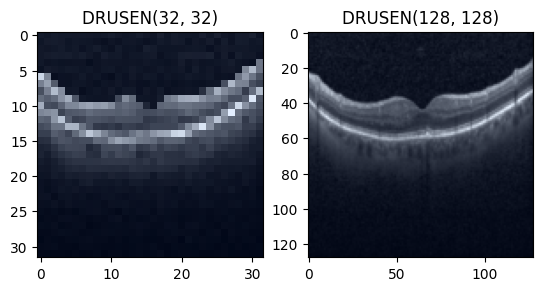

In [37]:
# Precalculated the number each class to ensure a balanced dataset
classTrainCount = {"DME":10847, "DRUSEN":8265} 

# Sets string definitions based on integer values
definitions = {0:"DME", 1:"DRUSEN"}

img_low, img_high, label = validate[0]
img_low = np.array(img_low.permute(1,2,0))
img_high = np.array(img_high).transpose((1, 2, 0))

# Normalize the pixel values to the range [0, 1] for visualization
img_low = (img_low - img_low.min()) / (img_low.max() - img_low.min())
img_high = (img_high - img_high.min()) / (img_high.max() - img_high.min())

# View some of the training data
fig, axes = plt.subplots(nrows=1, ncols=2)

# Plot the data on the subplots
axes[0].imshow(img_low)
axes[0].set_title(f"{definitions[label]}{config.low_res}")

axes[1].imshow(img_high)
axes[1].set_title(f"{definitions[label]}{config.high_res}")
plt.show()